In [48]:
#install and download needed packages
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings
import scipy
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict,KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.decomposition import PCA
from sklearn.svm import SVR
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
warnings.filterwarnings('ignore')
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset,TensorDataset
from sklearn.preprocessing import MinMaxScaler
import random
#Set random seeds
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed(42)
torch.cuda.manual_seed_all(42)  # for multi-GPU setups

# Ensure deterministic behavior
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

import os

os.environ['PYTHONHASHSEED'] = '42'

In [49]:
def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

In [50]:
data= pd.read_csv('lowa.csv')

In [51]:
data.head()

,invoice_and_item_number,date,store_number,store_name,address,city,zip_code,store_location,county_number,county,...,item_number,item_description,pack,bottle_volume_ml,state_bottle_cost,state_bottle_retail,bottles_sold,sale_dollars,volume_sold_liters,volume_sold_gallons
0,INV-33179700135,04/01/2021,2576,Hy-Vee Wine and Spirits / Storm Lake,1250 N Lake St,Storm Lake,50588.0,POINT (-95.200758 42.65318400000001),11.0,BUENA VIST,...,64870,Fireball Cinnamon Whiskey,48,100,0.90,1.35,48,64.80,4.8,1.26
1,INV-33196200106,04/01/2021,2649,Hy-Vee #3 / Dubuque,400 Locust St,Dubuque,52001.0,POINT (-90.666497 42.49721900000001),31.0,DUBUQUE,...,65200,Tequila Rose Liqueur,12,750,11.50,17.25,4,69.00,3.0,0.79
2,INV-33184300011,04/01/2021,2539,Hy-Vee Food Store / Iowa Falls,640 S. Oak,Iowa Falls,50126.0,POINT (-93.262364 42.508752),42.0,HARDIN,...,38008,Smirnoff 80prf PET,6,1750,14.75,22.13,6,132.78,10.5,2.77
3,INV-33184100015,04/01/2021,4024,Wal-Mart 1546 / Iowa Falls,840 S Oak,Iowa Falls,50126.0,POINT (-93.262446 42.503407),42.0,HARDIN,...,36648,Caliber Vodka,12,750,3.31,4.97,12,59.64,9.0,2.37
4,INV-33174200025,04/01/2021,5385,Vine Food & Liquor,2704 Vine St.,West Des Moines,50265.0,POINT (-93.741511 41.580206),77.0,POLK,...,4626,Buchanan Deluxe 12YR,12,750,20.99,31.49,2,62.98,1.5,0.39


In [52]:
data.shape

(1048575, 24)

In [53]:
data=data.drop(columns=['invoice_and_item_number','store_number', 'store_name','address','zip_code',
                        'store_location'],axis=1)

In [54]:
data.shape

(1048575, 18)

In [55]:
data.dtypes

date                    object
city                    object
county_number          float64
county                  object
category                 int64
category_name           object
vendor_number          float64
vendor_name             object
item_number              int64
item_description        object
pack                     int64
bottle_volume_ml         int64
state_bottle_cost      float64
state_bottle_retail    float64
bottles_sold             int64
sale_dollars           float64
volume_sold_liters     float64
volume_sold_gallons    float64
dtype: object

In [56]:
# Try converting 'date' to datetime with errors='coerce' to handle invalid formats
data['date'] = pd.to_datetime(data['date'], errors='coerce')

# Identify rows with NaT values (result of failed conversion)
invalid_dates = data[data['date'].isna()]
print(invalid_dates)

        date             city  county_number    county  category  \
69756    NaT     Cedar Rapids           57.0      LINN   1081600   
69757    NaT             Ames           85.0     STORY   1031100   
69758    NaT  West Des Moines           77.0      POLK   1031100   
69759    NaT      Mt Pleasant           44.0     Henry   1031100   
69760    NaT       Bettendorf           82.0     SCOTT   1032100   
...      ...              ...            ...       ...       ...   
1025513  NaT        Winterset           61.0   MADISON   1012100   
1025514  NaT           George           60.0      LYON   1012100   
1025515  NaT  Missouri Valley           43.0  HARRISON   1082200   
1025516  NaT       Sioux City           97.0  WOODBURY   1011100   
1025517  NaT       Sioux City           97.0  WOODBURY   1012100   

             category_name  vendor_number           vendor_name  item_number  \
69756      Whiskey Liqueur          421.0  SAZERAC COMPANY  INC        64870   
69757      American Vod

In [57]:
# Drop rows with NaT in the 'date' column
data = data.dropna(subset=['date'])

In [58]:
# Convert 'date' column with a specific format (if known)
data['date'] = pd.to_datetime(data['date'], format='%Y-%m-%d', errors='coerce')  # Adjust the format as needed

In [59]:
data.set_index('date', inplace=True)

<Axes: xlabel='date'>

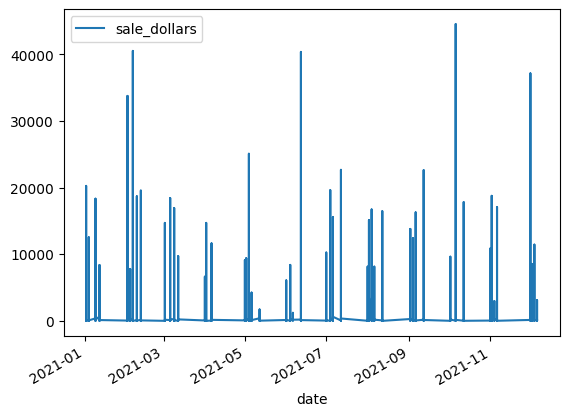

In [60]:
data.plot.line(y='sale_dollars', use_index=True)

In [61]:
data.describe()

,county_number,category,vendor_number,item_number,pack,bottle_volume_ml,state_bottle_cost,state_bottle_retail,bottles_sold,sale_dollars,volume_sold_liters,volume_sold_gallons
count,443219.000000,4.432560e+05,443256.000000,443256.000000,443256.000000,443256.000000,443256.000000,443256.000000,443256.000000,443256.000000,443256.000000,443256.000000
mean,57.343460,1.052365e+06,281.038529,54481.634313,12.011973,829.493054,11.209909,16.814816,11.923640,160.660579,9.461314,2.493812
std,27.585315,9.264904e+04,143.078650,91733.692813,7.926062,521.385626,12.072529,18.106108,30.265566,449.501116,36.253062,9.577274
min,1.000000,1.011100e+06,35.000000,258.000000,1.000000,20.000000,0.890000,1.340000,1.000000,1.340000,0.020000,0.000000
25%,31.000000,1.012100e+06,205.000000,27125.000000,6.000000,375.000000,6.000000,9.000000,3.000000,42.000000,1.500000,0.390000
50%,63.000000,1.031200e+06,260.000000,40053.000000,12.000000,750.000000,8.980000,13.470000,6.000000,90.000000,4.800000,1.260000
75%,77.000000,1.062500e+06,395.000000,65204.000000,12.000000,1000.000000,13.820000,20.730000,12.000000,166.500000,10.500000,2.770000
max,99.000000,1.901200e+06,978.000000,999930.000000,60.000000,5250.000000,1949.020000,2923.530000,3240.000000,44550.000000,5670.000000,1497.850000


In [62]:

#use label encoder
from sklearn.preprocessing import LabelEncoder
label_encoders = {}
for column in ['city','county', 'category', 'category_name','vendor_name','item_description']:
    label_encoders[column] = LabelEncoder()
    data[column] = label_encoders[column].fit_transform(data[column])

In [63]:
data.dtypes

city                     int64
county_number          float64
county                   int64
category                 int64
category_name            int64
vendor_number          float64
vendor_name              int64
item_number              int64
item_description         int64
pack                     int64
bottle_volume_ml         int64
state_bottle_cost      float64
state_bottle_retail    float64
bottles_sold             int64
sale_dollars           float64
volume_sold_liters     float64
volume_sold_gallons    float64
dtype: object

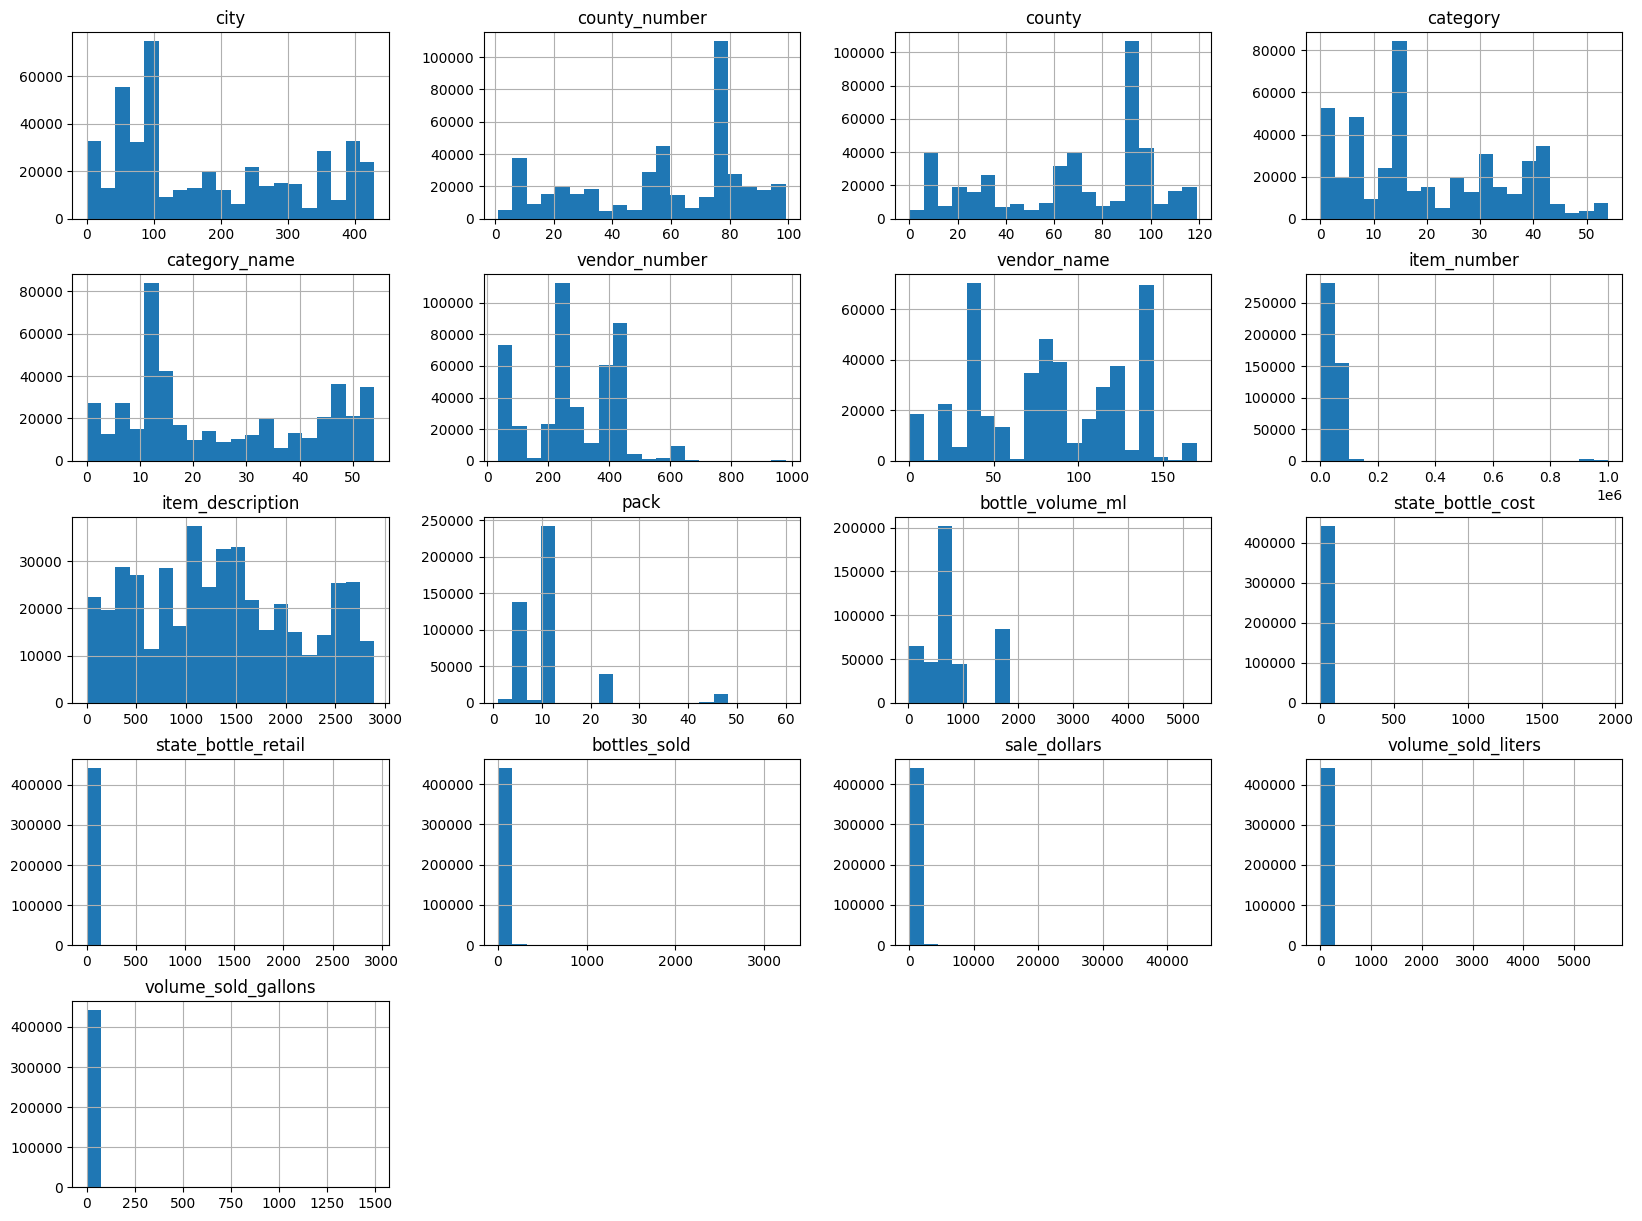

In [64]:
columns= ['city', 'county_number', 'county', 'category', 'category_name',
       'vendor_number', 'vendor_name', 'item_number', 'item_description',
       'pack', 'bottle_volume_ml', 'state_bottle_cost', 'state_bottle_retail',
       'bottles_sold', 'sale_dollars', 'volume_sold_liters',
       'volume_sold_gallons']
data[columns].hist( bins=20, figsize=(20,15));
#plt.savefig('charts_1.png')

<Axes: >

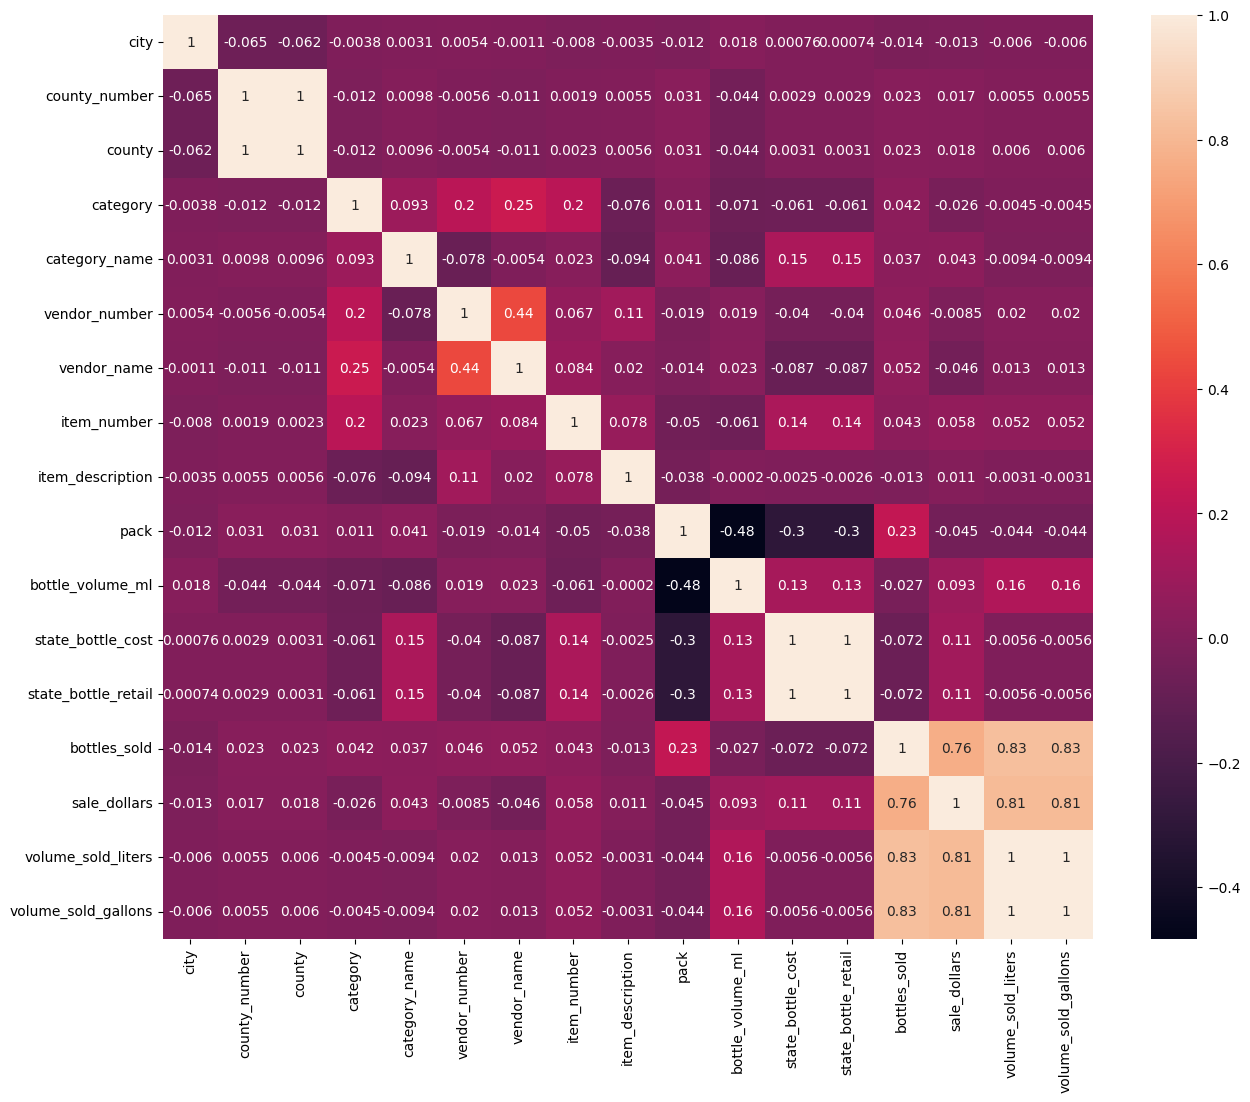

In [65]:
plt.figure(figsize=[15,12])
sns.heatmap(data.corr(), annot=True)

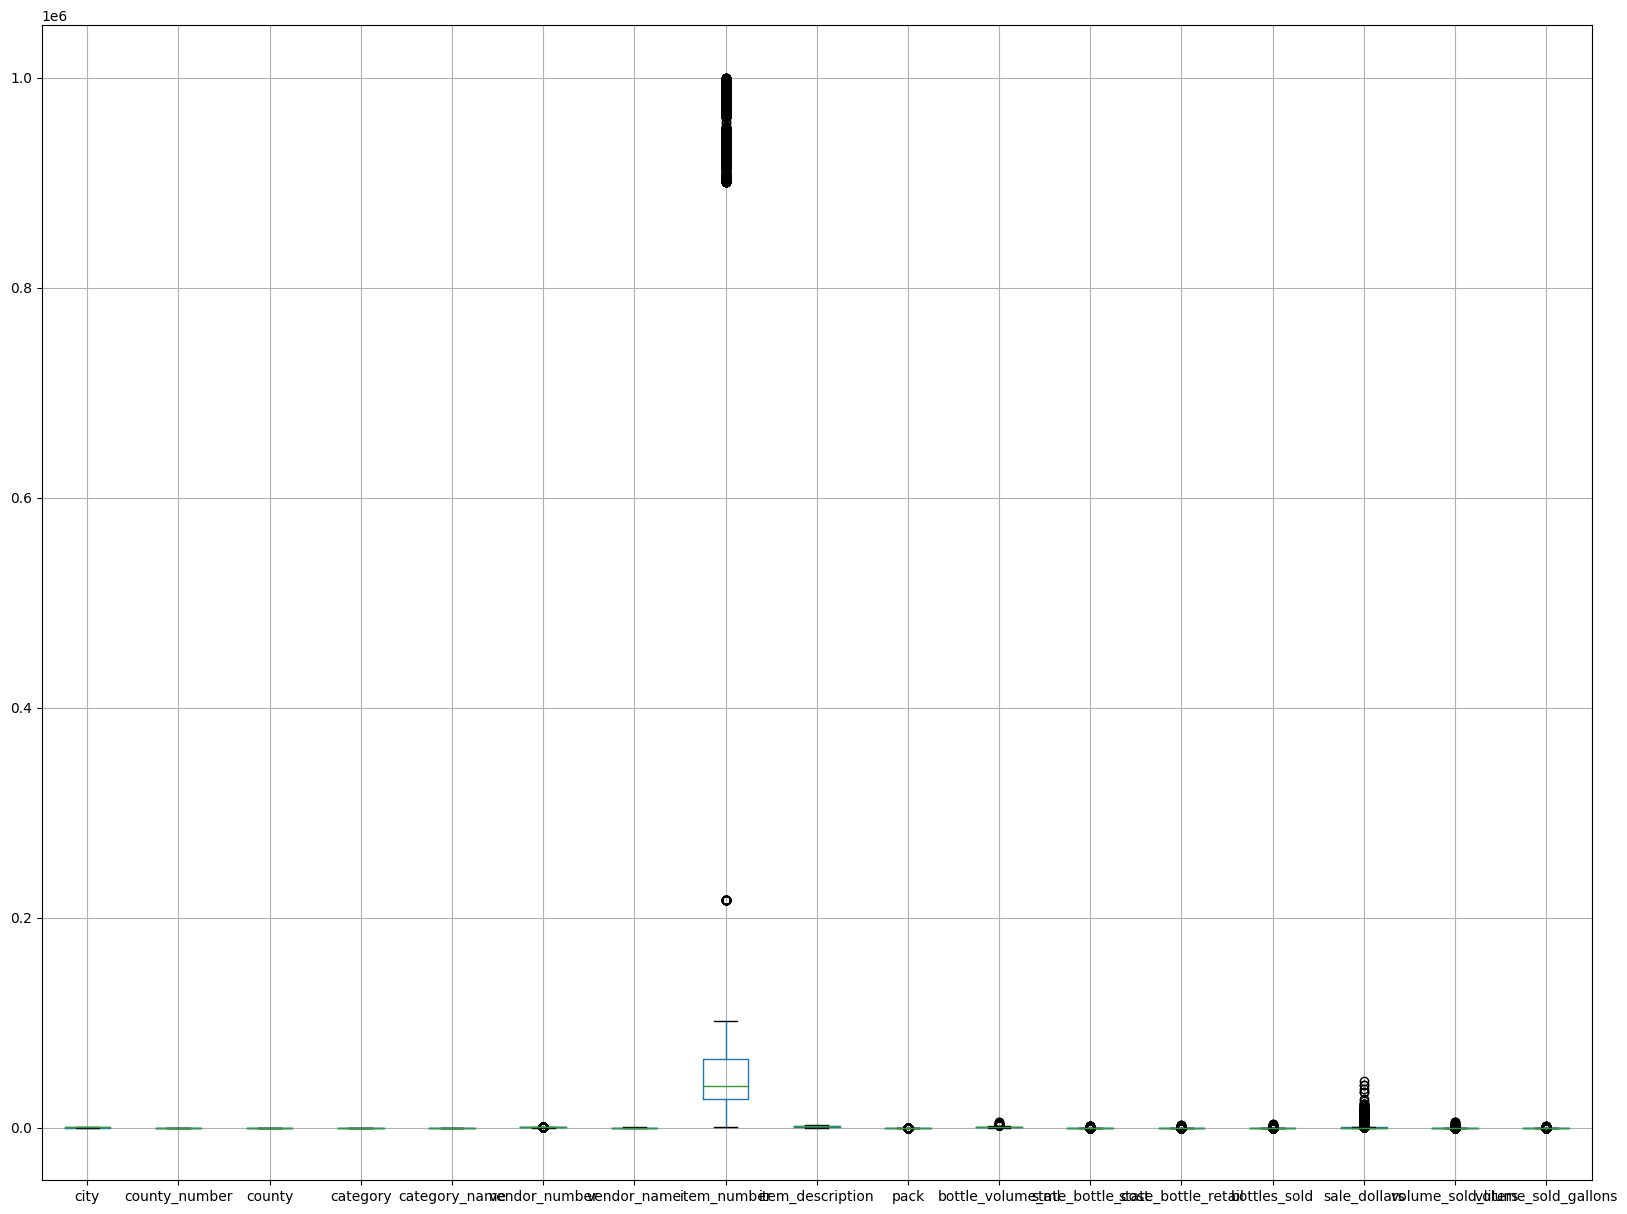

In [66]:
columns= ['city', 'county_number', 'county', 'category', 'category_name',
       'vendor_number', 'vendor_name', 'item_number', 'item_description',
       'pack', 'bottle_volume_ml', 'state_bottle_cost', 'state_bottle_retail',
       'bottles_sold', 'sale_dollars', 'volume_sold_liters',
       'volume_sold_gallons']
data[columns].boxplot(  figsize=(20,15));
#plt.savefig('charts_2.png')

In [67]:
data.duplicated().sum()

208297

In [68]:
data=data.dropna()

In [69]:
data.head()

,city,county_number,county,category,category_name,vendor_number,vendor_name,item_number,item_description,pack,bottle_volume_ml,state_bottle_cost,state_bottle_retail,bottles_sold,sale_dollars,volume_sold_liters,volume_sold_gallons
date,,,,,,,,,,,,,,,,,
2021-04-01,367,11.0,11,41,53,421.0,137,64870,1051,48,100,0.90,1.35,48,64.80,4.8,1.26
2021-04-01,107,31.0,32,37,20,300.0,103,65200,2654,12,750,11.50,17.25,4,69.00,3.0,0.79
2021-04-01,190,42.0,46,15,12,260.0,38,38008,2493,6,1750,14.75,22.13,6,132.78,10.5,2.77
2021-04-01,190,42.0,46,15,12,55.0,138,36648,501,12,750,3.31,4.97,12,59.64,9.0,2.37
2021-04-01,413,77.0,90,8,41,260.0,38,4626,438,12,750,20.99,31.49,2,62.98,1.5,0.39


In [70]:
data=data.drop_duplicates()

In [71]:
data.shape

(234924, 17)

### Feature Engineering


In [72]:
x = data.drop(columns=['sale_dollars'],axis=1)
y = data['sale_dollars']

In [73]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.2, random_state=40)
print("x_train shape:", x_train.shape)
print("x_test shape:", x_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

x_train shape: (187939, 16)
x_test shape: (46985, 16)
y_train shape: (187939,)
y_test shape: (46985,)


In [74]:
sales_data=data

### Feature selection using the "Variance Inflation Factor (VIF)" method.


In [75]:
# Utility function to return the VIF value for each feature provided
#from statsmodels.stats.outliers_influence import variance_inflation_factor

def compute_vif(x, sales_data):
    """
    Returns a DataFrame containing features and their corresponding variance inflation factor
    features: list of features whoes multicollinearity check is needed
    df: DataFrame of the data under review
    """
    from statsmodels.stats.outliers_influence import variance_inflation_factor
    import pandas as pd
    X = sales_data[x]
    X['intercept'] = 1
    # Create dataframe to store vif values
    vif = pd.DataFrame()
    vif['Feature'] = X.columns
    vif['Vif Factor'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    vif = vif[vif['Feature']!='intercept'].sort_values('Vif Factor', ascending=False)
    return vif


def select_features(train_df, threshold):

    """Returns two objects;
    1. a DataFrame containing features and their corresponding variance inflation factor, and
    2. Pandas Index object containing the list of features that have the least Multicollinearity in accordance with
        the supplied threshold.
    train_df: The training dataset whoes Multicollinearity is to be checked
    threshold: value to compare VIF value with, above which, the feature droped
    """
    data = train_df.copy()
    flag = True
    while flag:
        features_to_consider = data.columns
        # Calling the "compute_vif" utility function the Variance Inflation Factor dataframe
        sorted_vif_df = (compute_vif(features_to_consider, data).reset_index().drop('index', axis=1))

        # Get the highest vif value to compare against a threshold
        highest_vif = sorted_vif_df.at[0, 'Vif Factor']

        # Compare the highest_vif with a threshold (5 was decided for this problem by the team)
        if highest_vif > threshold: # or highest_vif=='inf':
            # Select the feature corresponding to the highest_vif (index 0 for both)
            feature = sorted_vif_df.at[0, 'Feature']
            # Drop the feature
            data.drop(feature, axis=1, inplace=True)

        else:
            flag = False
    return sorted_vif_df, data.columns

In [76]:

threshold = 5
vif_df, features = select_features(x_train, threshold)

In [77]:
display(vif_df)
print(features)

,Feature,Vif Factor
0,pack,1.401145
1,bottle_volume_ml,1.311385
2,vendor_name,1.243366
3,vendor_number,1.235931
4,state_bottle_cost,1.146951
5,category,1.113800
6,item_number,1.084339
7,category_name,1.042317
8,item_description,1.033130
9,bottles_sold,1.030524


Index(['city', 'county', 'category', 'category_name', 'vendor_number',
       'vendor_name', 'item_number', 'item_description', 'pack',
       'bottle_volume_ml', 'state_bottle_cost', 'bottles_sold'],
      dtype='object')


In [78]:
# make a dataframe of the selected features
X_train = x_train[features]
X_train.head()

,city,county,category,category_name,vendor_number,vendor_name,item_number,item_description,pack,bottle_volume_ml,state_bottle_cost,bottles_sold
date,,,,,,,,,,,,
2021-07-06,63,19,0,13,370.0,117,25990,2622,6,750,16.49,2
2021-06-12,207,97,15,12,434.0,89,36306,1268,12,750,3.34,12
2021-06-01,93,98,20,7,260.0,38,30318,1184,6,1750,11.00,6
2021-05-02,315,90,31,23,65.0,84,44419,771,12,750,7.00,2
2021-05-06,166,23,1,46,65.0,84,19226,1594,6,750,20.00,2


In [79]:
# Feature columns and target column
features = ['city', 'county', 'category', 'category_name', 'vendor_number',
       'vendor_name', 'item_number', 'item_description', 'pack',
       'bottle_volume_ml', 'state_bottle_cost', 'bottles_sold',
       'volume_sold_liters']
target = 'sale_dollars'

In [80]:
# Scale the data
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

x = scaler_X.fit_transform(data[features])
y = scaler_y.fit_transform(data[[target]])

In [81]:
# Split into train and test sets
train_size = int(0.8 * len(x))
x_train, x_test = x[:train_size], x[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [82]:
# Convert to PyTorch tensors
x_train_tensor = torch.tensor(x_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
x_test_tensor = torch.tensor(x_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

g = torch.Generator()
g.manual_seed(42)

# Create DataLoader
train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, worker_init_fn=seed_worker, generator=g)

## Define ResNet Model

In [83]:
class ResNetBlock(nn.Module):
    def __init__(self, in_features, out_features):
        super(ResNetBlock, self).__init__()
        self.fc1 = nn.Linear(in_features, out_features)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(out_features, out_features)
        self.fc_shortcut = nn.Linear(in_features, out_features) if in_features != out_features else None

    def forward(self, x):
        residual = x
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        if self.fc_shortcut:
            residual = self.fc_shortcut(residual)
        out += residual  # Add the input to the output (residual connection)
        return self.relu(out)

class ResNetModel(nn.Module):
    def __init__(self, input_size, output_size):
        super(ResNetModel, self).__init__()
        self.layer1 = ResNetBlock(input_size, 64)
        self.layer2 = ResNetBlock(64, 64)
        self.layer3 = ResNetBlock(64, 32)
        self.fc = nn.Linear(32, output_size)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.fc(out)
        return out

input_size = x_train.shape[1]
output_size = 1
model = ResNetModel(input_size, output_size)


In [84]:
# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [85]:

# Training parameters
num_epochs = 50
train_losses = []

# Training loop
model.train()
for epoch in range(num_epochs):
    epoch_loss = 0
    for x_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(x_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    epoch_loss /= len(train_loader)
    train_losses.append(epoch_loss)
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}')


Epoch 1/50, Loss: 0.0001
Epoch 2/50, Loss: 0.0000
Epoch 3/50, Loss: 0.0000
Epoch 4/50, Loss: 0.0000
Epoch 5/50, Loss: 0.0000
Epoch 6/50, Loss: 0.0000
Epoch 7/50, Loss: 0.0000
Epoch 8/50, Loss: 0.0000
Epoch 9/50, Loss: 0.0000
Epoch 10/50, Loss: 0.0000
Epoch 11/50, Loss: 0.0000
Epoch 12/50, Loss: 0.0000
Epoch 13/50, Loss: 0.0000
Epoch 14/50, Loss: 0.0000
Epoch 15/50, Loss: 0.0000
Epoch 16/50, Loss: 0.0000
Epoch 17/50, Loss: 0.0000
Epoch 18/50, Loss: 0.0000
Epoch 19/50, Loss: 0.0000
Epoch 20/50, Loss: 0.0000
Epoch 21/50, Loss: 0.0000
Epoch 22/50, Loss: 0.0000
Epoch 23/50, Loss: 0.0000
Epoch 24/50, Loss: 0.0000
Epoch 25/50, Loss: 0.0000
Epoch 26/50, Loss: 0.0000
Epoch 27/50, Loss: 0.0000
Epoch 28/50, Loss: 0.0000
Epoch 29/50, Loss: 0.0000
Epoch 30/50, Loss: 0.0000
Epoch 31/50, Loss: 0.0000
Epoch 32/50, Loss: 0.0000
Epoch 33/50, Loss: 0.0000
Epoch 34/50, Loss: 0.0000
Epoch 35/50, Loss: 0.0000
Epoch 36/50, Loss: 0.0000
Epoch 37/50, Loss: 0.0000
Epoch 38/50, Loss: 0.0000
Epoch 39/50, Loss: 0.

In [86]:
# Evaluation
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
model.eval()
with torch.no_grad():
    train_predict = model(x_train_tensor).cpu().numpy()
    test_predict = model(x_test_tensor).cpu().numpy()

train_predict = scaler_y.inverse_transform(train_predict)
test_predict = scaler_y.inverse_transform(test_predict)
y_train_inv = scaler_y.inverse_transform(y_train)
y_test_inv = scaler_y.inverse_transform(y_test)

train_rmse = np.sqrt(mean_squared_error(y_train_inv, train_predict))
test_rmse = np.sqrt(mean_squared_error(y_test_inv, test_predict))
train_mae = mean_absolute_error(y_train_inv, train_predict)
test_mae = mean_absolute_error(y_test_inv, test_predict)
train_r2 = r2_score(y_train_inv, train_predict)
test_r2 = r2_score(y_test_inv, test_predict)

print(f'Train RMSE: {train_rmse:.2f}, Train MAE: {train_mae:.2f}, Train R2: {train_r2:.2f}')
print(f'Test RMSE: {test_rmse:.2f}, Test MAE: {test_mae:.2f}, Test R2: {test_r2:.2f}')


Train RMSE: 102.36, Train MAE: 37.11, Train R2: 0.97
Test RMSE: 106.52, Test MAE: 39.06, Test R2: 0.97


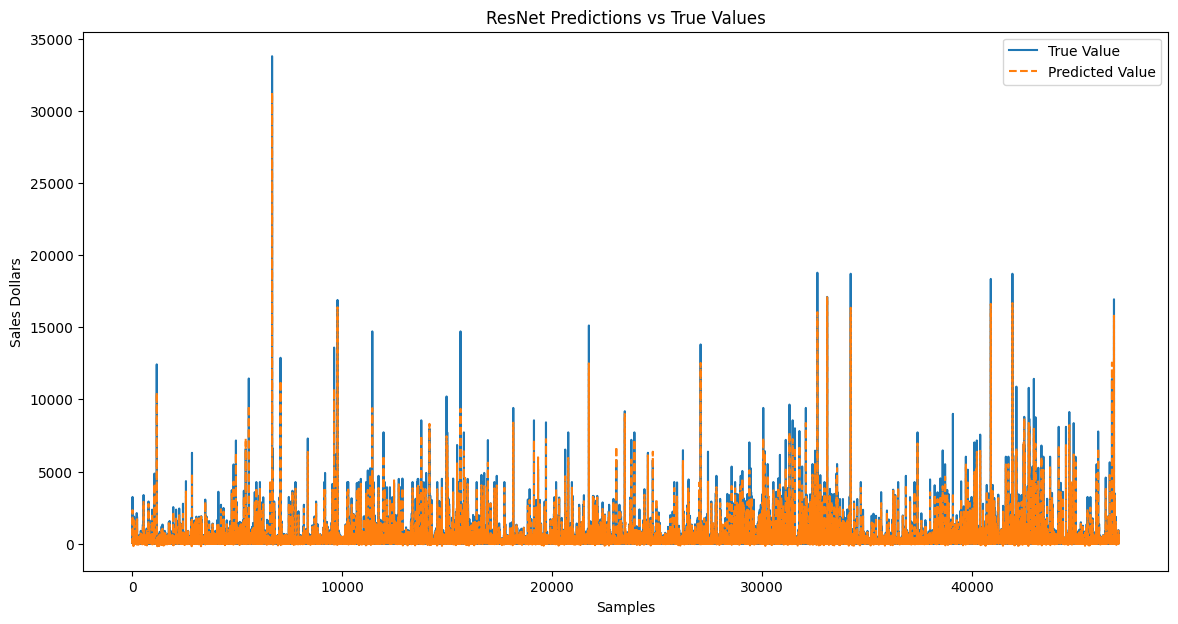

In [87]:
# Plot Predicted vs Actual for Test Data
plt.figure(figsize=(14, 7))
plt.plot(y_test_inv, label='True Value')
plt.plot(test_predict, label='Predicted Value', linestyle='--')
plt.title('ResNet Predictions vs True Values')
plt.xlabel('Samples')
plt.ylabel('Sales Dollars')
plt.legend()
plt.savefig('grupredicted.png')
plt.show()


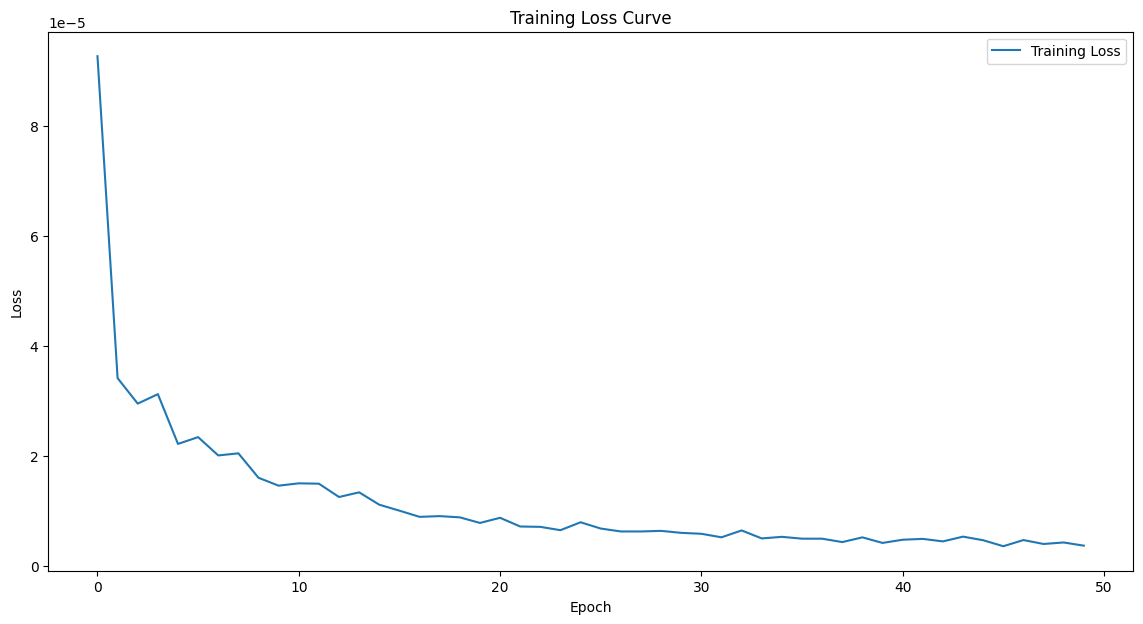

In [88]:
# Plot Training Loss
plt.figure(figsize=(14, 7))
plt.plot(train_losses, label='Training Loss')
plt.title('Training Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.savefig('grulosscurve.png')
plt.show()
